In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Literal
from scipy.stats import pearsonr

# Preprocessing

In [13]:
# 类：数据处理与分析

class TrajAnalysor():
    """数据处理与分析"""

    # 初始化
    def __init__(self, city: Literal['A', 'B', 'C', 'D']):
        self.city = city
        self.dataframe = pd.read_csv(self.get_path(), compression='gzip')
        self.masked_dataframe = self.dataframe
        self.unmasked_days = 75

    # 获取数据集路径
    def get_path(self):
        path_dict = {
            'A': './dataset/cityA_groundtruthdata.csv.gz',
            'B': './dataset/cityB_challengedata.csv.gz',
            'C': './dataset/cityC_challengedata.csv.gz',
            'D': './dataset/cityD_challengedata.csv.gz'
        }
        return path_dict.get(self.city, "Invalid City!")
    
    # 剔除数据
    def reinitial(self):
        """再初始化数据"""
        self.masked_dataframe = self.dataframe
        self.unmasked_days = 75

    def mask_users(self, reverse=False):
        """剔除待预测用户"""
        if self.city in ['B', 'C', 'D']:
            if reverse:
                df = self.masked_dataframe[self.masked_dataframe['uid'] >= len(pd.unique(self.dataframe['uid'])) - 3000]
            else:
                df = self.masked_dataframe[self.masked_dataframe['uid'] < len(pd.unique(self.dataframe['uid'])) - 3000]
        self.masked_dataframe = df
    
    def mask_points(self, reverse=False):
        """剔除待预测数据点"""
        if reverse:
            df = self.masked_dataframe[self.masked_dataframe['x'] == 999]
        else:
            df = self.masked_dataframe[self.masked_dataframe['x'] != 999]
        self.masked_dataframe = df

    def mask_days(self, reverse=False):
        """剔除待预测区间"""
        if reverse:
            df = self.masked_dataframe[self.masked_dataframe['d'] >= 60]
            self.unmasked_days = 15
        else:
            df = self.masked_dataframe[self.masked_dataframe['d'] < 60]
            self.unmasked_days = 60
        self.masked_dataframe = df
    
    def random_select_user(self, num_user=3000, random_seed=0):
        """随机选取用户"""
        assert num_user <= len(self.masked_dataframe['uid'].unique())
        random_users = self.masked_dataframe['uid'].sample(n=num_user,random_state=random_seed).unique()
        self.masked_dataframe = self.masked_dataframe[self.masked_dataframe['uid'].isin(random_users)]
        
    # 距离统计量
    def euclidean_distance(self, group, is_sum=True):
        """辅助函数：计算欧式距离"""
        distances = np.sqrt(np.diff(group['x'])**2 + np.diff(group['y'])**2)
        if is_sum:
            return distances.sum()
        else:
            return distances
    
    def distance_peruser(self):
        dpu = self.masked_dataframe.groupby('uid').apply(self.euclidean_distance)
        return dpu
    
    def distance_peruser_perday(self):
        dpp = self.masked_dataframe.groupby(['uid', 'd']).apply(self.euclidean_distance)
        return dpp
        
    def distance_perstep(self):
        dps = []
        for _, traj in self.masked_dataframe.groupby('uid'):
            distances = self.euclidean_distance(traj, is_sum=False)
            dps.extend(distances)
        dps = np.array(dps)
        return dps

    # 计数统计量
    def count_peruser(self):
        cpu = self.masked_dataframe.groupby('uid').size()
        return cpu.to_numpy()
    
    def count_peruser_perday(self):
        cpp = self.masked_dataframe.groupby(['uid', 'd']).size()
        return cpp.to_numpy()
    
    # 时间统计量
    def histogram_data_count(self):
        days = 75
        timeslots = 48  
        data_count = np.zeros((days,timeslots), dtype=int)
        for (day, timeslot), data in self.masked_dataframe.groupby(['d', 't']):
            data_count[day][timeslot] += len(data)
        return data_count.flatten()
    
    def histogram_move_count(self):
        days = 75
        timeslots = 48  
        timestamp_counts = np.zeros(days * timeslots, dtype=int)

        for _, traj in self.masked_dataframe.groupby('uid'):
            x_prev = traj[0]['x']
            y_prev = traj[0]['y']
            for _, row in traj.iterrows():
                if (row['x'] != x_prev) or (row['y'] != y_prev):
                    day = row['d']
                    timeslot = row['t']
                    index = day * timeslots + timeslot
                    timestamp_counts[index] += 1
                x_prev = row['x']
                y_prev = row['y']
    
        return timestamp_counts
    
    #绘制柱状图

    def get_data(self, type):
        """获取统计数据"""
        type_dict = {
            'dpu': self.distance_peruser,
            'dpp': self.distance_peruser_perday,
            'dps': self.distance_perstep,
            'cpu': self.count_peruser,
            'cpp': self.count_peruser_perday,
        }
        if type in type_dict:
            return type_dict[type]()
        else:
            raise ValueError("Invalid type!")
    
    def plot_bar(self,
                 type: Literal['dpu', 'dpp', 'dps', 'cpu', 'cpp'],
                 binstamp=100, freq_normalize=True, dis_normalize=False):
        """绘制数据分布柱状图，频数及距离可归一化"""
        
        # 标题和标签字典
        def switch_title(type, city, total_days):
            title_dict = {
                'dpu': f'Distribution of distance/user during 1-{str(total_days)} day for city {city}',
                'dpp': f'Distribution of distance/(user*day) during 1-{str(total_days)} day for city {city}',
                'dps': f'Distribution of distance/step during 1-{str(total_days)} day for city {city}',
                'cpu': f'Distribution of counts/user for city {city}',
                'cpp': f'Distribution of counts/(user*day) for city {city}',
                }
            xlabel_dict = {
                'dpu': 'distance',
                'dpp': 'distance',
                'dps': 'distance',
                'cpu': 'count',
                'cpp': 'count',
            }
            return title_dict.get(type, "Invalid type!"), xlabel_dict.get(type, "Invalid type!")

        # 柱状图参数
        data_array = self.get_data(type)
        counts, bins = np.histogram(data_array, bins=binstamp)
        title, x_label = switch_title(type, self.city, self.unmasked_days)
        y_label = 'Frequency'

        # 计算平均数,中位数,最大值和最小值
        mean = np.mean(data_array)
        median = np.median(data_array)
        max = np.max(data_array)
        min = np.min(data_array)

        # 归一化
        if freq_normalize:
            total_counts = np.sum(counts)
            counts = counts / total_counts
            y_label = y_label + f'(normalized, max= {str(total_counts)})'
        
        if dis_normalize:
            total_dis = bins[-1]
            bins[:] = bins[:] / total_dis
            mean, median = mean / total_dis, median / total_dis
            x_label = x_label + f'(normalized, max= {str(total_dis)})'

        # 绘制柱状图
        plt.figure()
        plt.bar(bins[:-1], counts, width=np.diff(bins), edgecolor='black', alpha=0.7)

        # 标注平均数
        plt.axvline(mean, color='red', linestyle='--', linewidth=1, label=f'Mean: {mean:.3f}')
        plt.text(mean, plt.ylim()[1] * 0.9, f'Mean: {mean:.3f}', color='red', ha='left', va='center')
        # 标注中位数
        plt.axvline(median, color='green', linestyle='--', linewidth=1, label=f'Median: {median:.3f}')
        plt.text(median, plt.ylim()[1] * 0.8, f'Median: {median:.3f}', color='green', ha='left', va='center')
        # 添加最大值的标注
        plt.axvline(max, color='black', linestyle='--', linewidth=1, label=f'Max: {max:.3f}')
        plt.text(max, plt.ylim()[1] * 0.6, f'Max: {max:.3f}', color='black', ha='left', va='center')
        # 添加最小值的标注
        plt.axvline(min, color='black', linestyle='--', linewidth=1, label=f'Min: {min:.3f}')
        plt.text(min, plt.ylim()[1] * 0.6, f'Min: {min:.3f}', color='black', ha='left', va='center')

        # 标题和标签
        plt.title(title)
        plt.xlabel(x_label)
        plt.ylabel(y_label)

        # 显示图像
        plt.show()
    
    # 函数：绘制折线图
    
    def get_histogram(self, type):
        histogram_dict = {
            'data': self.histogram_data_count,
            'move': self.histogram_move_count,
        }
        if type in histogram_dict:
            return histogram_dict[type]()
        else:
            raise ValueError("Invalid type!")

    def plot_histogram(self,
                       type: Literal['data', 'move']):
        """绘制单城市时间轴折线图"""
        timeslot_count = self.get_histogram(type)

        # 绘制折线图
        plt.figure(figsize=(80, 5))
        plt.plot(timeslot_count, linestyle='-', color='blue')

        # 设置坐标轴范围
        plt.xlim(0, len(timeslot_count) - 1)  # 使 x 轴范围覆盖整个数据
        plt.ylim(min(timeslot_count), max([max(timeslot_count), 1000]))  # 使 y 轴范围覆盖所有数据点

        # 生成连续的时间序列刻度并设置刻度标签
        x_ticks = np.arange(0, (75 + 1) * 48, 48)  # 每48个timeslot为一天
        x_tick_labels = [f'Day {i}' for i in range(75 + 1)]
        plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=30)

        # 标题标签
        plt.title(f'{type} Counts Histogram for city {self.city}')
        plt.xlabel('Day')
        plt.ylabel('Counts')

        # 显示图像
        plt.show()

    # 函数：绘制热力图
    def plot_heatmap(self, 
                     grid_sizes = [10, 20, 50],     # 热力图粒度列表
                     log=False):
        """绘制轨道数据集的不同粒度下的空间分布热力图"""

        # 提取空间信息
        x_values = self.masked_dataframe['x'].to_numpy()
        y_values = self.masked_dataframe['y'].to_numpy()

        # 设置子图属性
        fig, axes = plt.subplots(1, len(grid_sizes), figsize=(18, 6))

        for i, grid_size in enumerate(grid_sizes):
            # 计算每个网格的边界
            x_bins = np.linspace(np.min(x_values), np.max(x_values), grid_size)
            y_bins = np.linspace(np.min(y_values), np.max(y_values), grid_size)

            # 统计每个网格中的数据点数量
            heatmap, _, _ = np.histogram2d(x_values, y_values, bins=[x_bins, y_bins])
            if log:
                heatmap = np.log1p(heatmap)

            # 绘制热力图
            im = axes[i].imshow(heatmap.T, origin='lower', cmap='Blues', interpolation='nearest')

            # 添加标题
            axes[i].set_title(f'Grid Size: {grid_size}x{grid_size} for City {self.city}')
            axes[i].set_xlabel('X')
            axes[i].set_ylabel('Y')

            # 添加颜色
            plt.colorbar(im, ax=axes[i])

        # 调整布局
        plt.tight_layout()
        plt.show()
    
        

In [7]:
# 函数：绘制折线图

def plot_histograms(*arrs, type: Literal['Data', 'Move'], log=False, 
                     cities = ['A','B','C','D']):
    """绘制多城市时间轴折线图"""
    colors = ['red', 'blue', 'green', 'orange']

    plt.figure(figsize=(80, 5))
    for i, arr in enumerate(arrs):
        if log:
            arr = np.log1p(arr)
        color = colors[i % len(colors)]
        plt.plot(arr, label=f'City {cities[i]}', color=color)

    # 添加图例
    plt.legend()

    # 设置坐标轴范围
    plt.xlim(0, len(arr) - 1)  # 使 x 轴范围覆盖整个数据

    # 生成连续的时间序列刻度并设置刻度标签
    x_ticks = np.arange(0, (75 + 1) * 48, 48)  # 每48个timeslot为一天
    x_tick_labels = [f'Day {i}' for i in range(75 + 1)]
    plt.xticks(ticks=x_ticks, labels=x_tick_labels, rotation=30)

    # 标题标签\n",
    plt.title(f'{type} Counts Histograms for each City')
    plt.xlabel('Day')
    plt.ylabel('Counts')

    # 显示图表
    plt.show()

In [8]:
# 函数：绘制相关性散点图

def plot_multi_scatter(ref_arr, *arrs,
                       type:Literal['counts', 'distance'] = 'counts'):
    num_arrs = len(arrs)
    name_list = ['A', 'B', 'C', 'D']
    plt.figure(figsize=(14, 5 * num_arrs))

    for i, series in enumerate(arrs):
        correlation, _ = pearsonr(ref_arr, series)

        plt.subplot(num_arrs, 1, i + 1)
        plt.scatter(ref_arr, series, color='blue', alpha=0.6)
        
        # 添加线性拟合直线
        m, b = np.polyfit(ref_arr, series, 1)
        plt.plot(ref_arr, m * ref_arr + b, color='red', linestyle='--', linewidth=2)

        # 设置标题和轴标签
        plt.title(f'Scatter Plot of Reference between {name_list[0]} and {name_list[i+1]} (Correlation: {correlation:.4f})')
        plt.xlabel(f'{type} for city {name_list[0]}')
        plt.ylabel(f'{type} for city {name_list[i+1]}')

    # 调整子图间距
    plt.tight_layout()
    plt.show()

In [14]:
A = TrajAnalysor('A')
B = TrajAnalysor('B')
C = TrajAnalysor('C')
D = TrajAnalysor('D')

In [81]:
A.dataframe[:10]

,uid,d,t,x,y
0,0,0,1,79,86
1,0,0,2,79,86
2,0,0,8,77,86
3,0,0,9,77,86
4,0,0,19,81,89
5,0,0,20,82,88
6,0,0,21,81,89
7,0,0,22,81,89
8,0,0,24,76,86
9,0,0,25,75,82


# Distance Statistics

## Distribution of distance peruser

/var/folders/dh/7984j7ln2b9005qghdnnbqbc0000gn/T/ipykernel_26745/1492793603.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dpu = self.masked_dataframe.groupby('uid').apply(self.euclidean_distance)


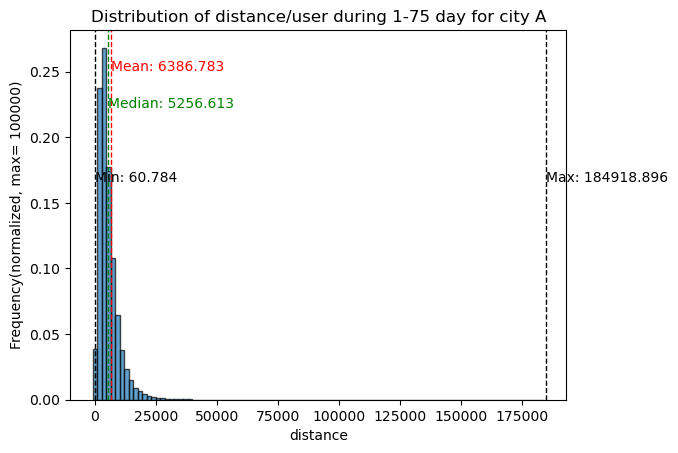

In [82]:
A.reinitial()
A.plot_bar('dpu')

/var/folders/dh/7984j7ln2b9005qghdnnbqbc0000gn/T/ipykernel_26745/1492793603.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dpu = self.masked_dataframe.groupby('uid').apply(self.euclidean_distance)


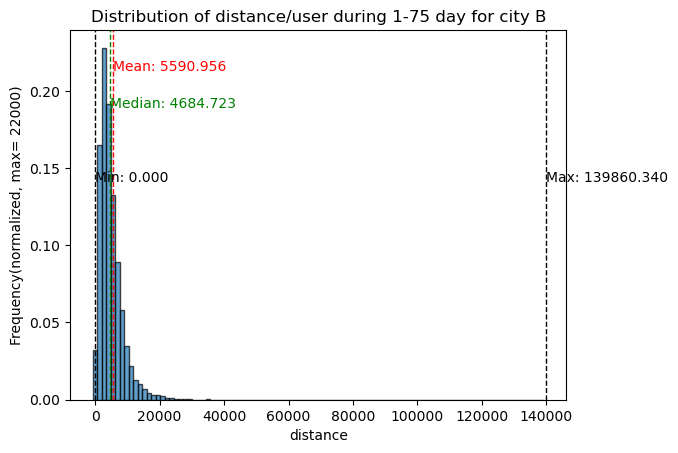

In [83]:
B.reinitial()
B.mask_users()
B.plot_bar('dpu')

/var/folders/dh/7984j7ln2b9005qghdnnbqbc0000gn/T/ipykernel_26745/1492793603.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dpu = self.masked_dataframe.groupby('uid').apply(self.euclidean_distance)


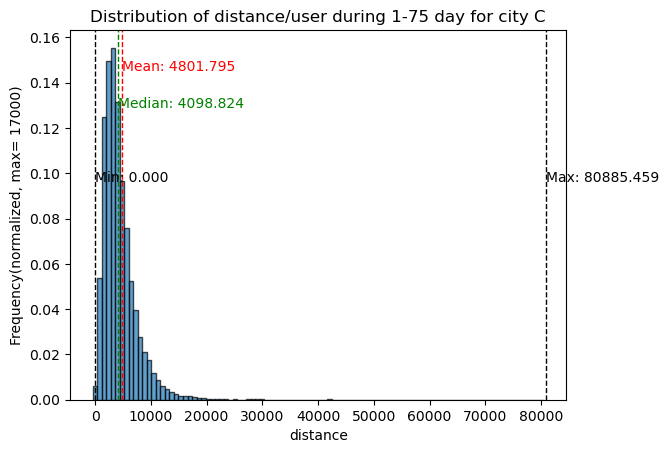

In [84]:
C.reinitial()
C.mask_users()
C.plot_bar('dpu')

/var/folders/dh/7984j7ln2b9005qghdnnbqbc0000gn/T/ipykernel_26745/1492793603.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dpu = self.masked_dataframe.groupby('uid').apply(self.euclidean_distance)


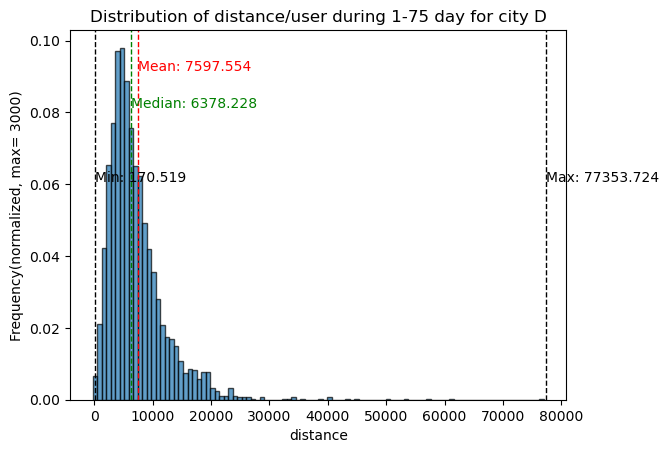

In [85]:
D.reinitial()
D.mask_users()
D.plot_bar('dpu')

## Distribution of distance perstep

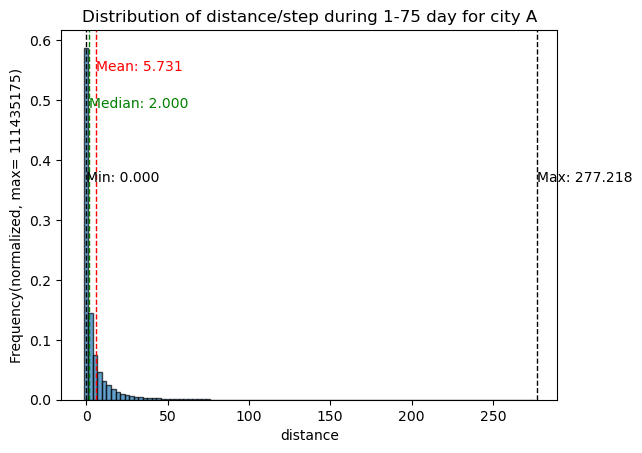

In [86]:
A.reinitial()
A.plot_bar('dps')

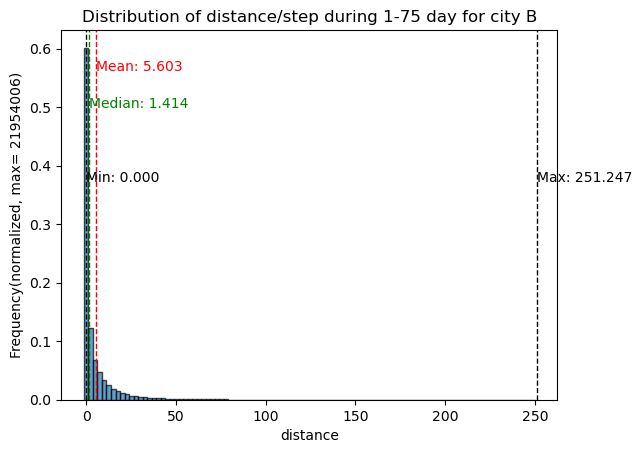

In [87]:
B.reinitial()
B.mask_users()
B.plot_bar('dps')

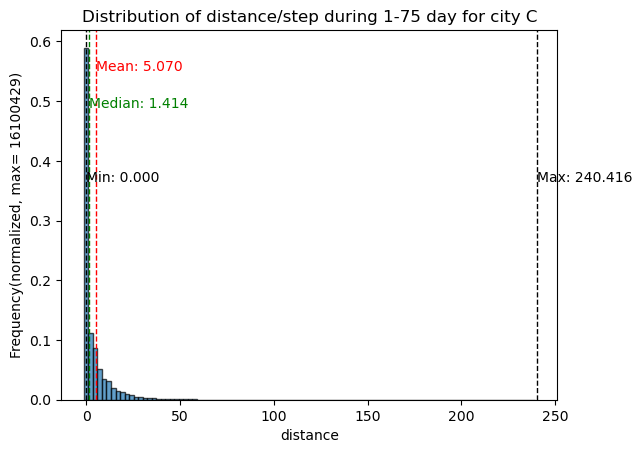

In [88]:
C.reinitial()
C.mask_users()
C.plot_bar('dps')

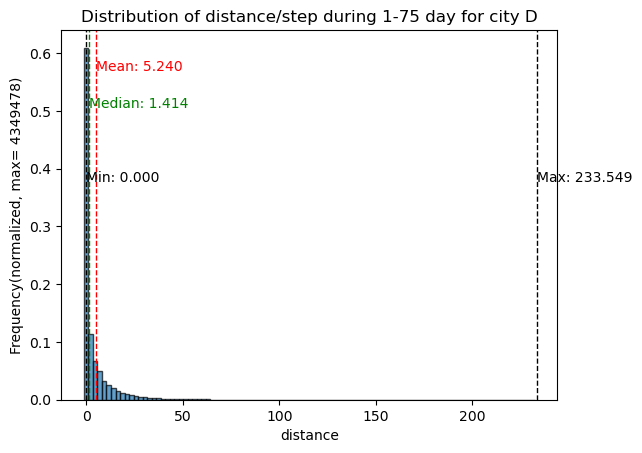

In [89]:
D.reinitial()
D.mask_users()
D.plot_bar('dps')

# Count Statistics

## Distribution of count peruser

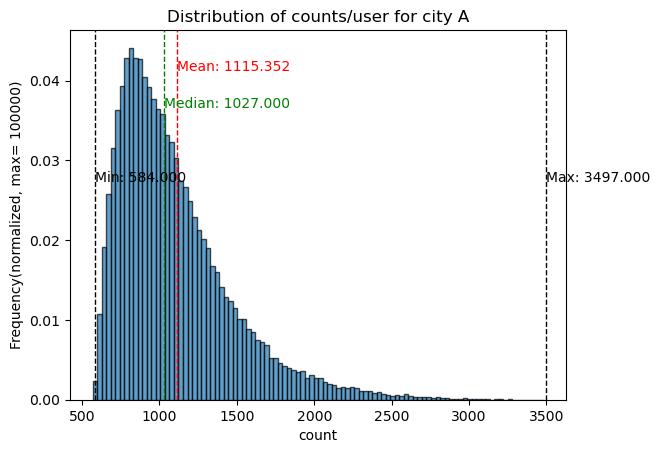

In [90]:
A.reinitial()
A.plot_bar('cpu')

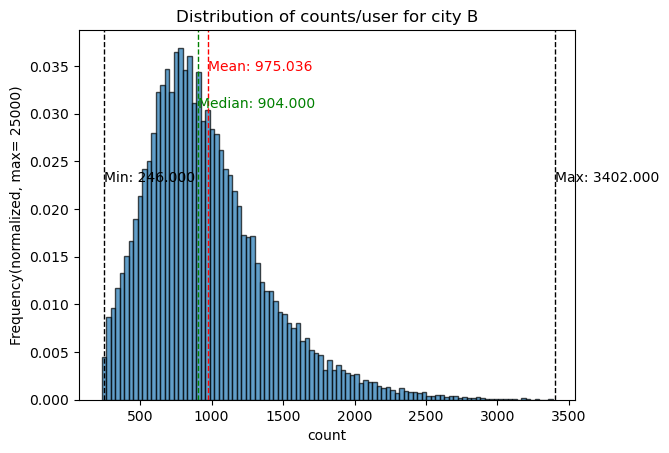

In [91]:
B.reinitial()
B.plot_bar('cpu')

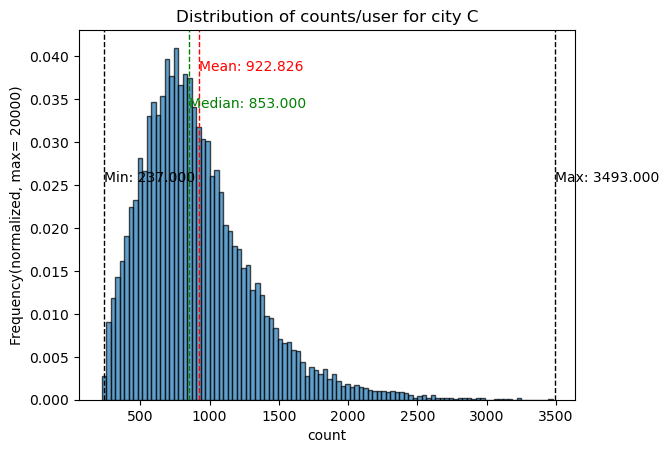

In [92]:
C.reinitial()
C.plot_bar('cpu')

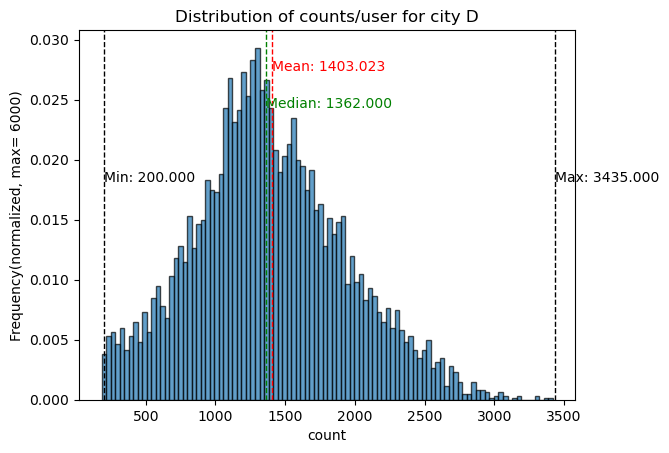

In [93]:
D.reinitial()
D.plot_bar('cpu')

# Temporal Statistics

In [15]:
for city, analyser in zip(['B', 'C', 'D'],[B, C, D]):
    length = []
    analyser.reinitial()
    analyser.mask_days(reverse=True)
    analyser.mask_points(reverse=True)
    for _, data in analyser.masked_dataframe.groupby('d'):
        length.append(len(data))
    print(f'city{city} data count for each day during 61-75:\n{length}\n')

cityB data count for each day during 61-75:
[27631, 29500, 29167, 27711, 29710, 31814, 33802, 31586, 32864, 30955, 27685, 31630, 33401, 32914, 32446]

cityC data count for each day during 61-75:
[28557, 29341, 27915, 24919, 29783, 31006, 32331, 31033, 33040, 28809, 27057, 31041, 31624, 31248, 31604]

cityD data count for each day during 61-75:
[55196, 57174, 51596, 45680, 56110, 58546, 65679, 59396, 57548, 49668, 44252, 56476, 56591, 55630, 55191]



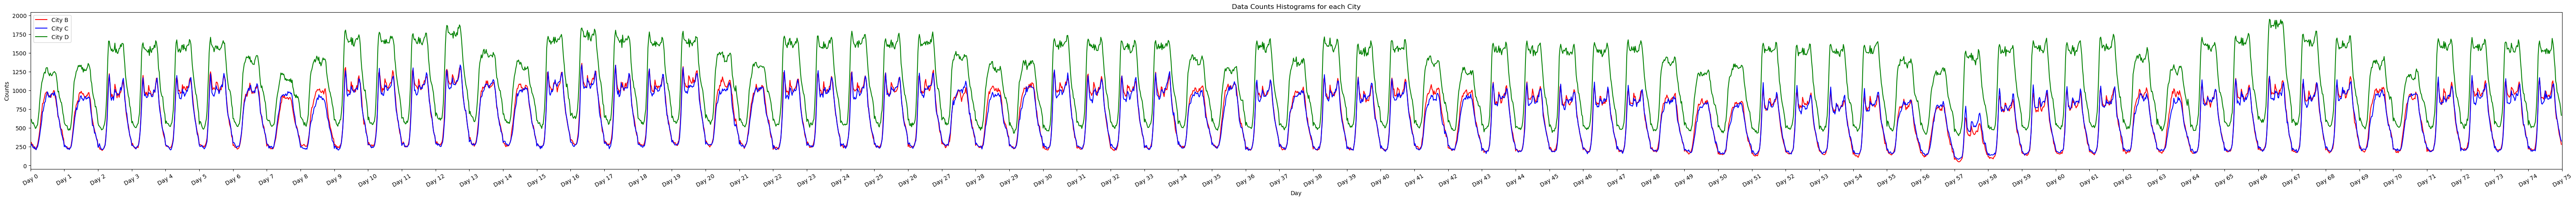

In [16]:
data_count_arrs = []
cities = ['B', 'C', 'D']
for city, analyser in zip(cities, [B, C, D]):
    data_count = np.zeros((75, 48))
    analyser.reinitial()
    analyser.mask_users(reverse=True)
    data_count_arrs.append(analyser.histogram_data_count())
plot_histograms(data_count_arrs[0], data_count_arrs[1], data_count_arrs[2],
                type='Data', log=False, cities=cities)

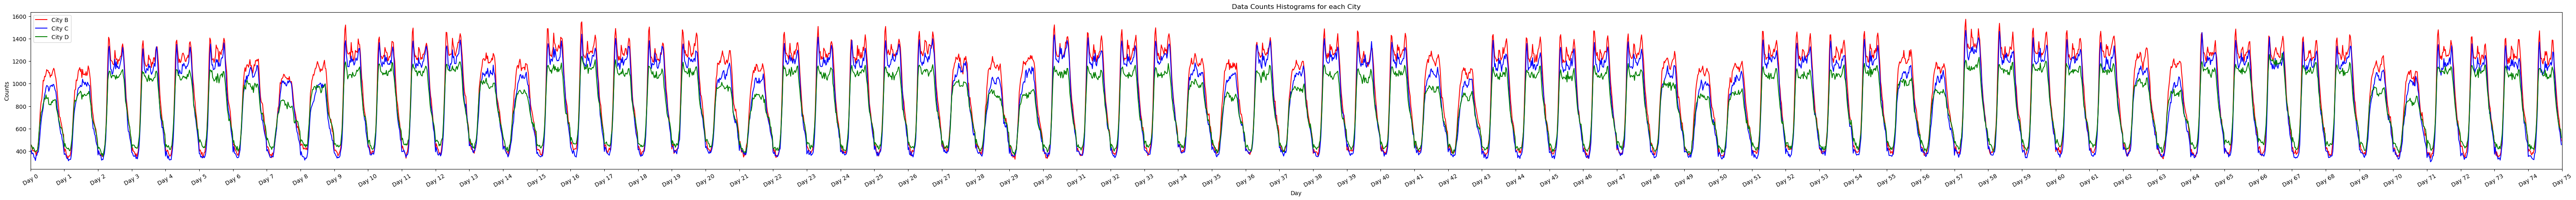

In [18]:
data_count_arrs = []
cities = ['B', 'C', 'D']
for city, analyser in zip(cities, [B, C, D]):
    data_count = np.zeros((75, 48))
    analyser.reinitial()
    analyser.mask_users()
    analyser.random_select_user()
    data_count_arrs.append(analyser.histogram_data_count())
plot_histograms(data_count_arrs[0], data_count_arrs[1], data_count_arrs[2],
                type='Data', log=False, cities=cities)

# Spatial Statistics

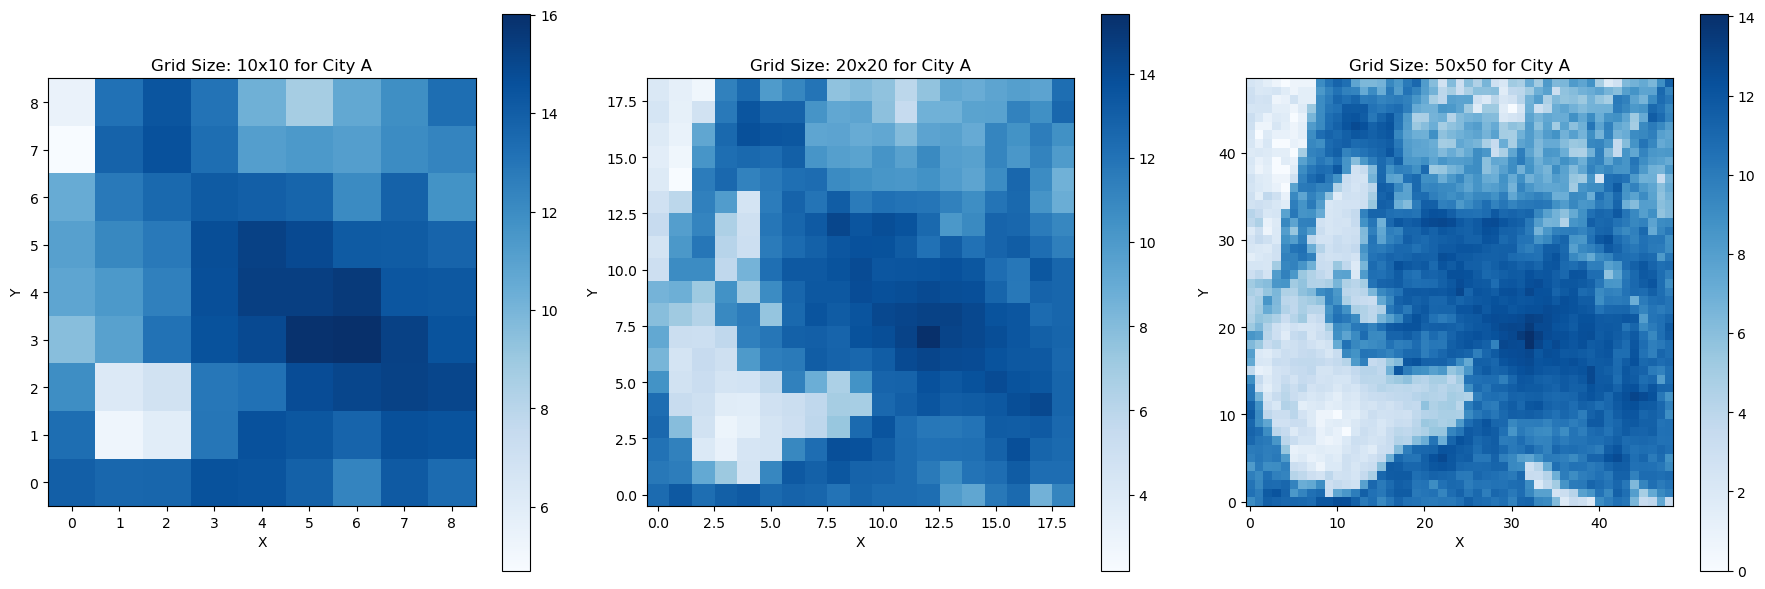

In [95]:
A.reinitial()
A.plot_heatmap(log=True)

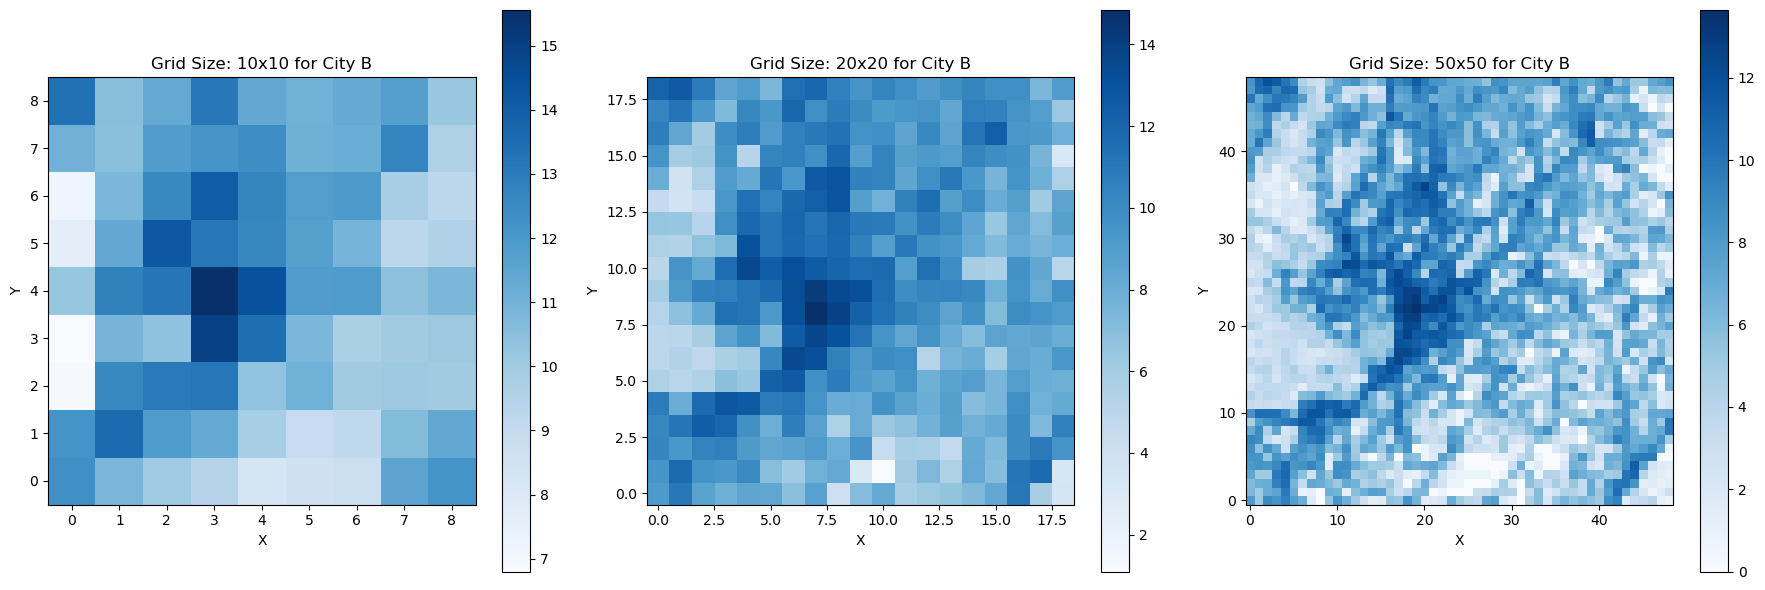

In [96]:
B.reinitial()
B.mask_points()
B.plot_heatmap(log=True)

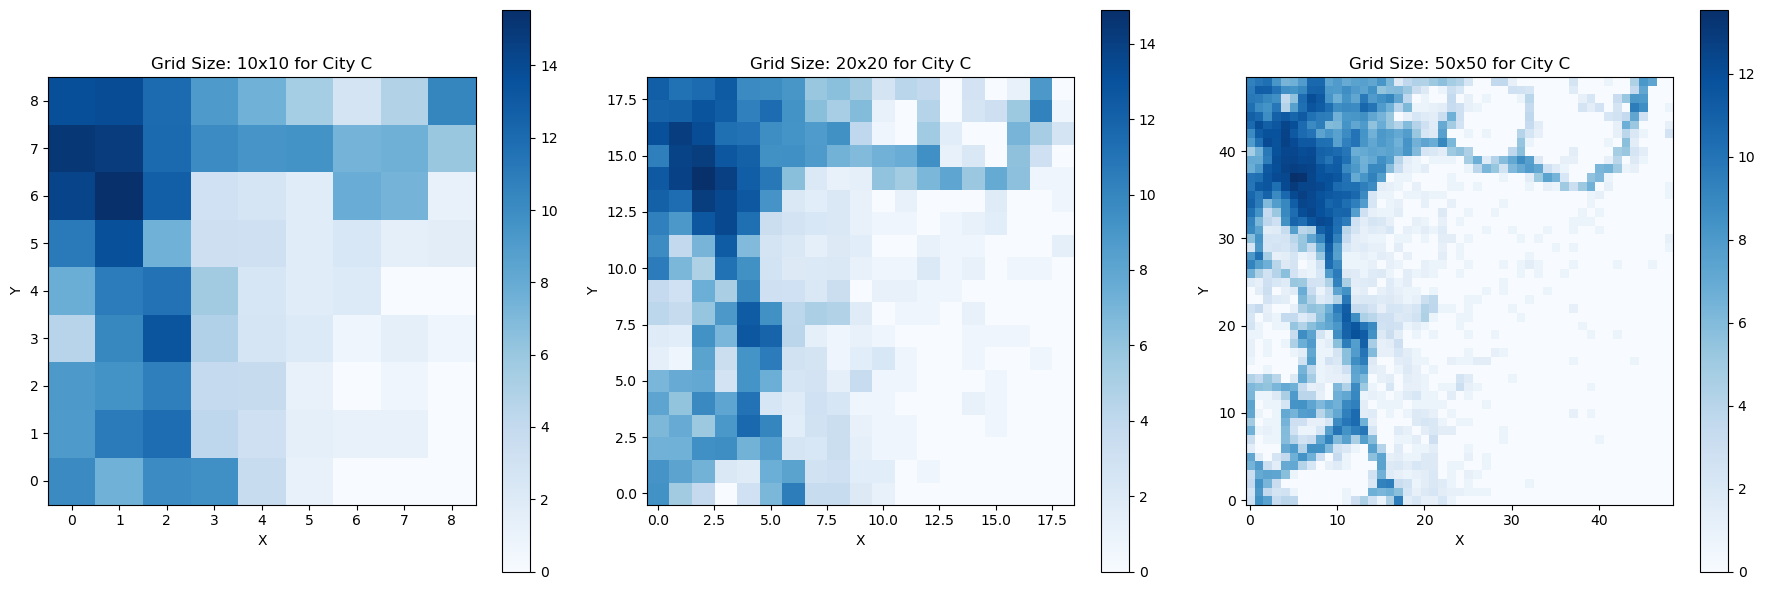

In [97]:
C.reinitial()
C.mask_points()
C.plot_heatmap(log=True)

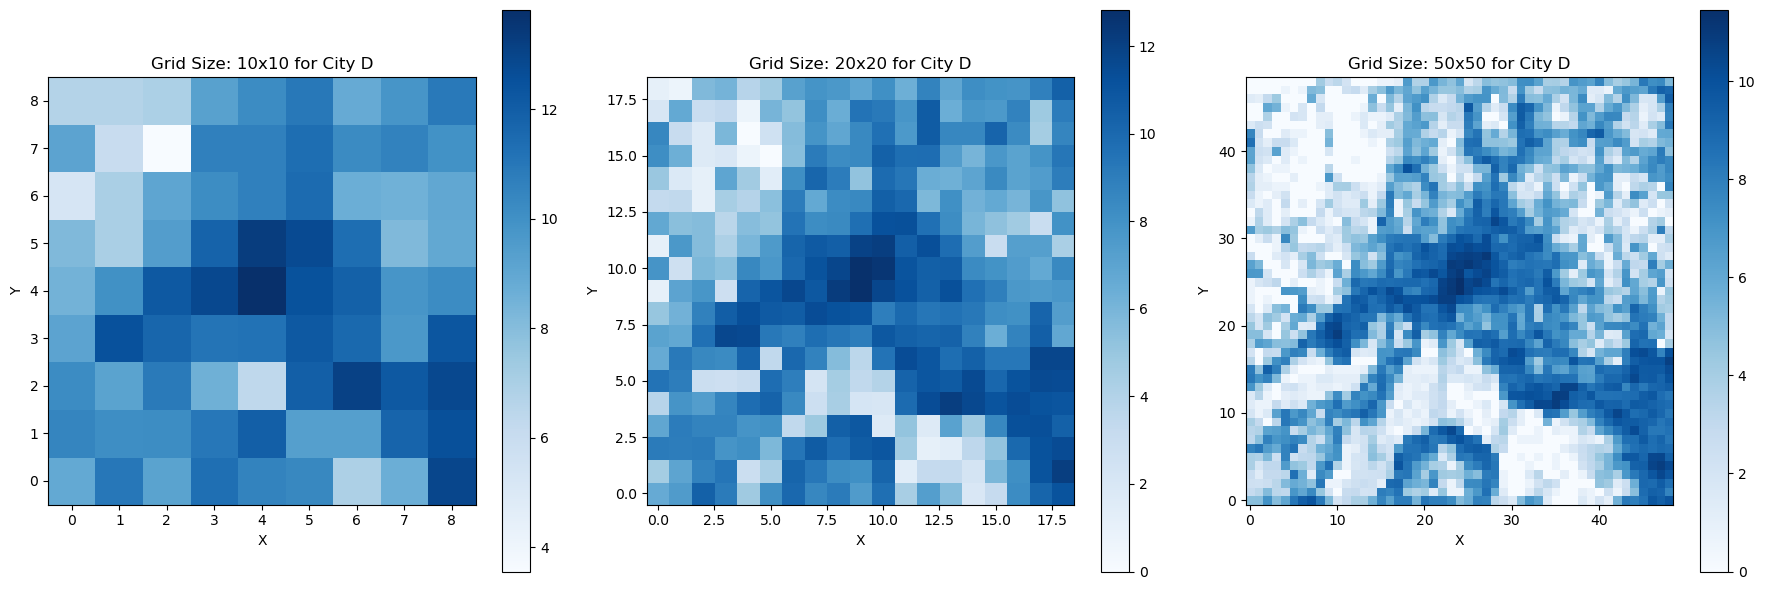

In [98]:
D.reinitial()
D.mask_points()
D.plot_heatmap(log=True)